In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

# The Black-Scholes hedging strategy

## 1. Simulating $S_t$

In [3]:
T = 1

We will simulate sample paths $(W_{t_i})_i$ of the brownian motion $W_t$.

In [55]:
@numba.njit("int32,float64")
def brownian(n, T):
    dt = T/n
    Zi = dt**0.5*np.random.randn(n)
    res = np.zeros((n+1,))
    res[1:] = np.cumsum(Zi)
    return res

In [56]:
def process(n, T, mu, sigma, S0=100):
    t_vals = np.linspace(0, T, n+1, endpoint=True)
    Wt = brownian(n, T)
    exponents = (mu - 0.5*sigma*sigma)*t_vals+sigma*Wt
    return S0*np.exp(exponents)

In [57]:
n_samples = 1000

Text(0, 0.5, 'Price $S_t$')

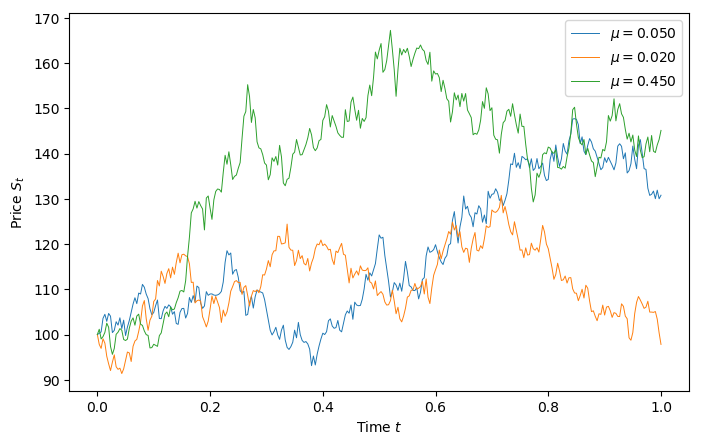

In [58]:
n = 300
S0 = 100
sigma = 0.3
fig, ax = plt.subplots(1,1,figsize=(8,5),dpi=100)
t_vals = np.linspace(0, T, n+1, endpoint=True)
mu_val_list = [0.05, 0.02, 0.45]

sample_data = []

for mu in mu_val_list:
    sample_data.append([process(n, T, mu, sigma) for _ in range(n_samples)])
    graph_traj = sample_data[-1][0]
    ax.plot(t_vals, graph_traj, linewidth=0.7,
            label=r"$\mu = %.3f$" % mu)
sample_data = np.array(sample_data)
ax.legend()
ax.set_xlabel("Time $t$")
ax.set_ylabel("Price $S_t$")

In [59]:
sample_data.shape

(3, 1000, 301)

In [60]:
for i, mu in enumerate(mu_val_list):
    print("Drift value: %.3f" % mu)
    mean = np.mean(sample_data[i,:,-1])
    variance = np.var(sample_data[i,:,-1], ddof=1)
    print(" | sample mean S_T: %.4f" % mean)
    print(" | sample variance S_T: %.4f" % variance)

Drift value: 0.050
 | sample mean S_T: 106.1980
 | sample variance S_T: 1074.8643
Drift value: 0.020
 | sample mean S_T: 100.2988
 | sample variance S_T: 887.5018
Drift value: 0.450
 | sample mean S_T: 154.4507
 | sample variance S_T: 2235.1879


Higher drift leads to a higher mean $W_T$, but also greater variance. This can be seen by writing
$$\begin{align*}
    \mathbb E[S_T] &= \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)T\right)\mathbb E\left[\exp(\sigma W_T) \right] \\
    \mathrm{Var}\left(S_T\right) &= \exp((2\mu-\sigma^2)T)\mathrm{Var}\left(\exp(\sigma W_T)\right)
\end{align*}
$$

# 2 Hedging

In [61]:
from scipy.stats import norm as scnorm

In [83]:
def bs_function(S0, K, T, sigma, r):
    s = S0
    k = K*np.exp(-r*T)
    v = sigma*sigma*T
    base = np.log(s/k)/np.sqrt(v)
    dm, dp = (base - 0.5*np.sqrt(v), base + 0.5*np.sqrt(v))
    return S0*scnorm.cdf(dp) - k*scnorm.cdf(dm)

We then define $\Delta_t(K)$ according to model parameters:

In [90]:
def delta_function(S, K, T, t, sigma, r=0.05):
    s = S0
    k = K*np.exp(-r*(T-t))
    v = sigma*sigma*(T-t)
    dp = np.log(s/k)/np.sqrt(v) + 0.5*np.sqrt(v)
    return scnorm.cdf(dp)

In [91]:
def xtn(n, T, K, S0, mu, sigma, r=0.05):
    bs = bs_function(S0, K, T, sigma, r)
    t_vals = np.linspace(0, T, n+1, endpoint=True)
    t_vals_dec = t_vals[:-1]
    t_vals = t_vals[1:]
    deltas = delta_function(S0, K, T, t_vals_dec, sigma, r)
    St = process(n, T, mu, sigma, S0)
    St_dec = St[:-1]
    St = St[1:]
    res = bs + np.sum(deltas*(np.exp(-r*t_vals)*St - np.exp(-r*t_vals_dec)*St_dec), axis=0)
    return np.exp(r*T)*res

We define once again our model parameters:

In [107]:
n = 300
S0 = 100
sigma = 0.3
t_vals = np.linspace(0, T, n+1, endpoint=True)
mu_val_list = [0.05, 0.02, 0.45]
K_val_list = list(range(80,121))

In [113]:
n_samples = 1000

sample_data = []
for K in K_val_list:
    print("Computing samples for K=%.3f" % K)
    K_sample_data = []
    print("  Computing for mu = ",end='\t')
    for mu in mu_val_list:
        print("%.3f" % mu, end='\t')
        K_sample_data.append([xtn(n, T, K, S0, mu, sigma) for _ in range(n_samples)])
    print()
    sample_data.append(K_sample_data)

Computing samples for K=80.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=81.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=82.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=83.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=84.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=85.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=86.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=87.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=88.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=89.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=90.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=91.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=92.000
  Computing for mu = 	0.050	0.020	0.450	
Computing samples for K=93.000
  Computing for mu = 	0.050	0.020

In [114]:
# Make a numpy array out of our samples, it's easier to manipulate
sample_data = np.array(sample_data)

In [115]:
print(sample_data.shape)

(41, 3, 1000)


We will now compute the means over all 1000 samples for every value of $\mu$ and $K$, and plot them:

In [116]:
mean_matrix = sample_data.mean(axis=2)

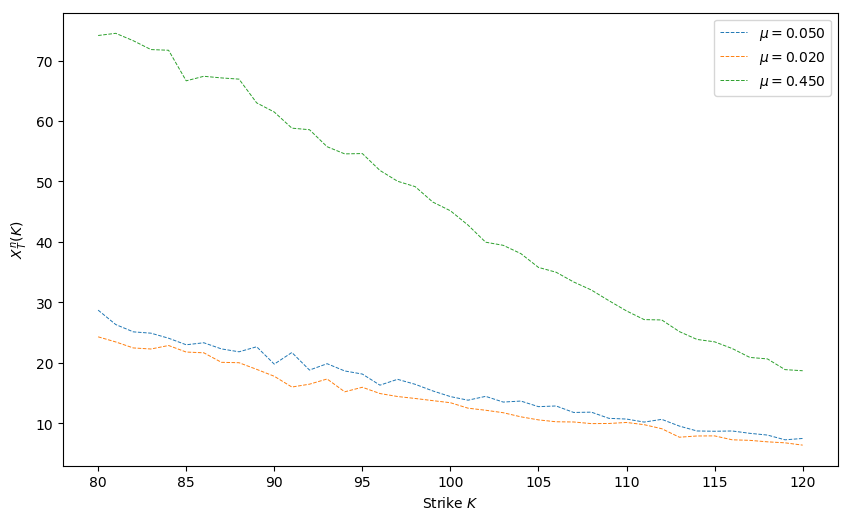

In [120]:
fig, ax = plt.subplots(1,1,figsize=(10,6),dpi=100)
ax.set_xlabel("Strike $K$")
ax.set_ylabel("$X_T^n(K)$")

for i, mu in enumerate(mu_val_list):
    ax.plot(K_val_list, mean_matrix[:,i], linestyle='--', label=r"$\mu=%.3f$" % mu, linewidth=0.7)

ax.legend()

We can see that higher values of the drift (which means higher mean asset price and variance at time $T$) lead to faster decrease of the portfolio value $X^n_T(K)$ with respect to the strike $K$, with higher starting value.

Indeed, higher drift means higher expected return on the asset at $T$ but with more uncertainty, and a higher strike will decrease the value more quickly.

In [121]:
def profit_loss(n, T, K, S0, mu, sigma, r=0.05):
    bs = bs_function(S0, K, T, sigma, r)
    t_vals = np.linspace(0, T, n+1, endpoint=True)
    t_vals_dec = t_vals[:-1]
    t_vals = t_vals[1:]
    deltas = delta_function(S0, K, T, t_vals_dec, sigma, r)
    St = process(n, T, mu, sigma, S0)
    Sfinal = St[-1]
    St_dec = St[:-1]
    St = St[1:]
    res = bs + np.sum(deltas*(np.exp(-r*t_vals)*St - np.exp(-r*t_vals_dec)*St_dec), axis=0)
    res = np.exp(r*T)*res
    return res - max(0, Sfinal - K)

In [150]:
# Compute samples of the 
n_samples = 1000
n_val_list = [128, 512, 1024, 2048]

pnl_sample_data = []
print("=== Profit and loss ===")
for n in n_val_list:
    print("Computing samples for n=%d" % n)
    n_sample_data = []
    for K in K_val_list:
        print("  for K=%.3f" % K, end='')
        K_sample_data = []
        for mu in mu_val_list:
            K_sample_data.append([profit_loss(n, T, K, S0, mu, sigma) for _ in range(n_samples)])
        print(' done')
        n_sample_data.append(K_sample_data)
    pnl_sample_data.append(n_sample_data)

=== Profit and loss ===
Computing samples for n=128
  for K=80.000 done
  for K=81.000 done
  for K=82.000 done
  for K=83.000 done
  for K=84.000 done
  for K=85.000 done
  for K=86.000 done
  for K=87.000 done
  for K=88.000 done
  for K=89.000 done
  for K=90.000 done
  for K=91.000 done
  for K=92.000 done
  for K=93.000 done
  for K=94.000 done
  for K=95.000 done
  for K=96.000 done
  for K=97.000 done
  for K=98.000 done
  for K=99.000 done
  for K=100.000 done
  for K=101.000 done
  for K=102.000 done
  for K=103.000 done
  for K=104.000 done
  for K=105.000 done
  for K=106.000 done
  for K=107.000 done
  for K=108.000 done
  for K=109.000 done
  for K=110.000 done
  for K=111.000 done
  for K=112.000 done
  for K=113.000 done
  for K=114.000 done
  for K=115.000 done
  for K=116.000 done
  for K=117.000 done
  for K=118.000 done
  for K=119.000 done
  for K=120.000 done
Computing samples for n=512
  for K=80.000 done
  for K=81.000 done
  for K=82.000 done
  for K=83.000 done

In [151]:
pnl_sample_data = np.array(pnl_sample_data)
print(pnl_sample_data.shape)

(4, 41, 3, 1000)


In [152]:
mean_matrix = np.mean(pnl_sample_data, axis=-1)
var_matrix = np.var(pnl_sample_data, axis=-1, ddof=1)

### Mean of the Profit-Loss

We plot the mean of $PL_T^n(K)$ against the strike and $n$, with different values of the drift $\mu$.

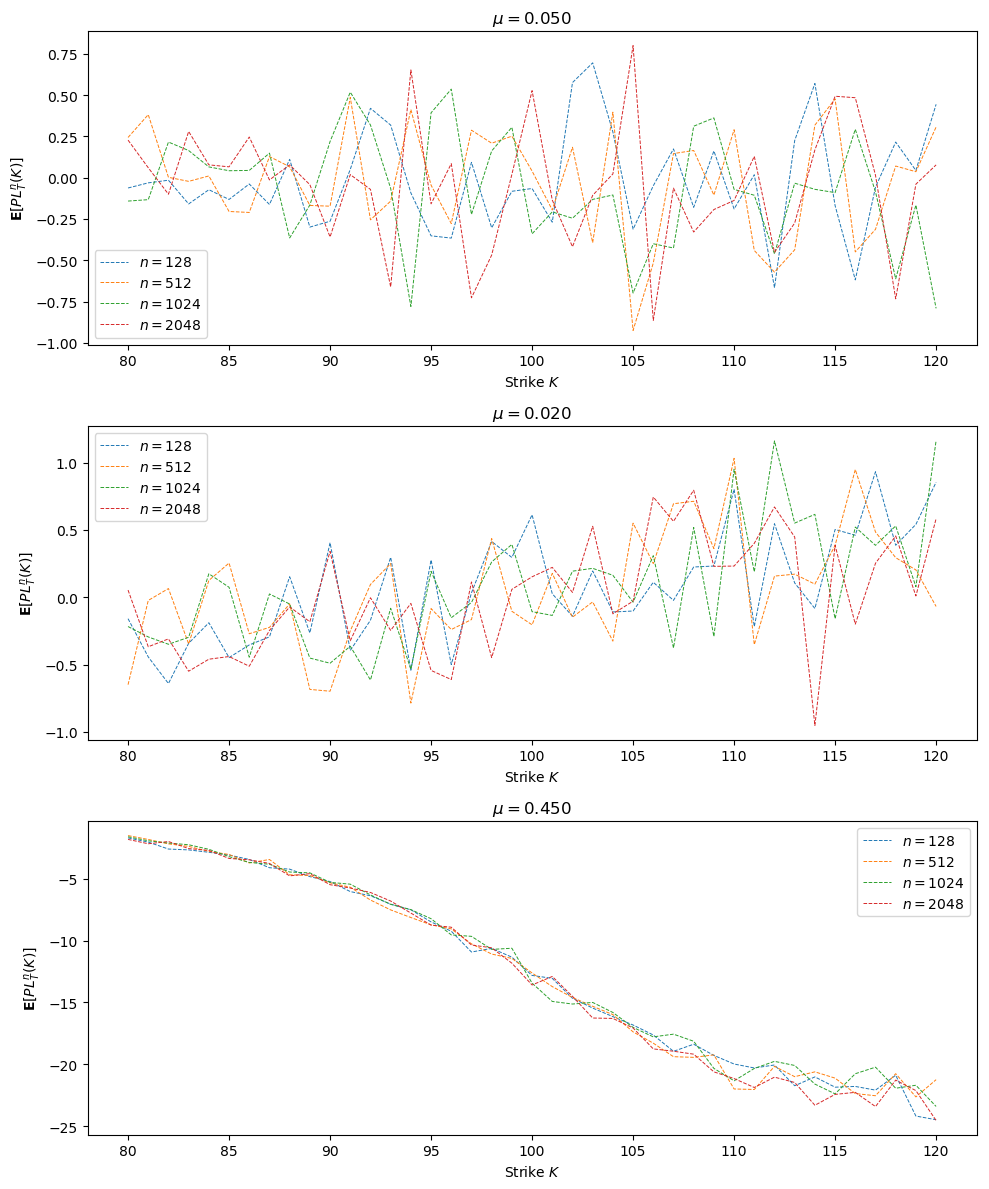

In [153]:
fig, axes = plt.subplots(3,1,figsize=(10,12),dpi=100)

for i, mu in enumerate(mu_val_list):
    for j, n in enumerate(n_val_list):
        axes[i].plot(
            K_val_list, mean_matrix[j,:,i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathbf{E}[PL_T^n(K)]$")
fig.tight_layout()

We again see the effect of the drift on the slope, but also that changing the simulation step doesn't change much.

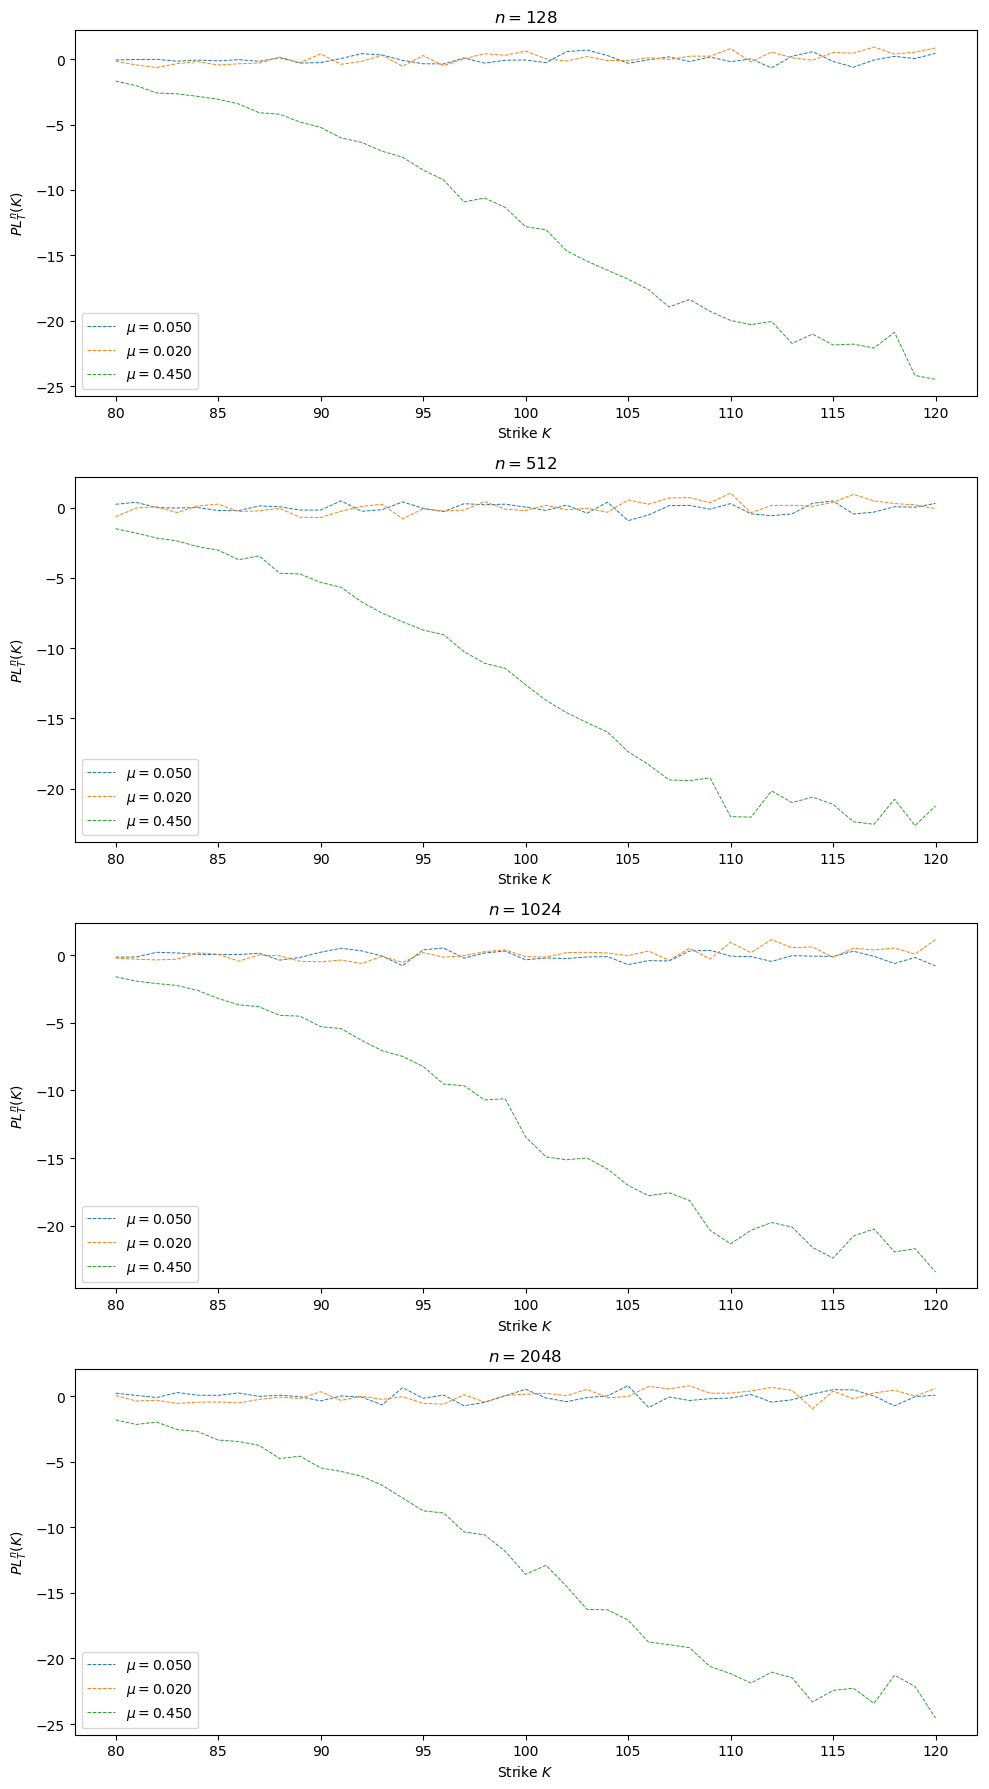

In [154]:
fig, axes = plt.subplots(len(n_val_list),1,figsize=(10,18),dpi=100)

for i, n in enumerate(n_val_list):
    for j, mu in enumerate(mu_val_list):
        axes[i].plot(
            K_val_list, mean_matrix[i,:,j],
            linestyle='--', label=r"$\mu=%.3f$" % mu, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$n=%d$" % n)
    axes[i].set_ylabel("$PL_T^n(K)$")
fig.tight_layout()

### Variance of the Profit-Loss

And now for the **variance** of the Profit-Loss:

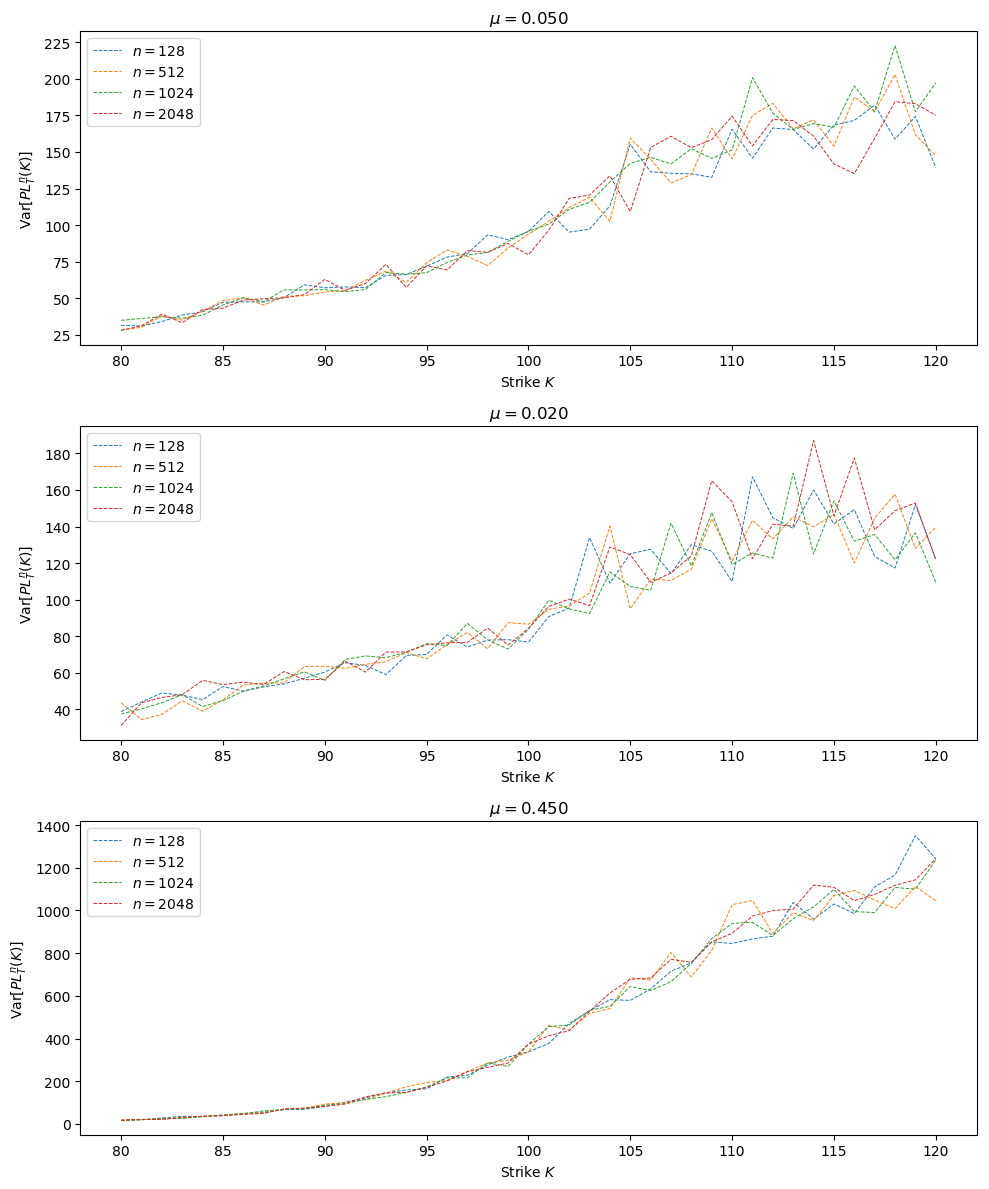

In [155]:
fig, axes = plt.subplots(3,1,figsize=(10,12),dpi=100)

for i, mu in enumerate(mu_val_list):
    for j, n in enumerate(n_val_list):
        axes[i].plot(
            K_val_list, var_matrix[j,:,i],
            linestyle='--', label=r"$n=%d$" % n, linewidth=0.7)
    axes[i].set_xlabel("Strike $K$")
    axes[i].legend()
    axes[i].set_title(r"$\mu=%.3f$" % mu)
    axes[i].set_ylabel(r"$\mathrm{Var}[PL_T^n(K)]$")
fig.tight_layout()